# 1. Import libraries

In [27]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [29]:
#Create path
path = r'/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Prepared Data'
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# 2. Loading Dataset

In [30]:
# 1) Load two datasets
# X = weather observations (already scaled)
weather = pd.read_pickle(os.path.join(path, 'weather_scaled.pkl'))
# y = pleasant/unpleasant answers
answers = pd.read_csv(os.path.join(path, 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))

print("Weather shape:", weather.shape)
print("Answers shape:", answers.shape)

Weather shape: (22950, 171)
Answers shape: (22950, 16)


In [31]:
# 2) Drop unwanted stations
drop_stations = ["TOURS", "ROMA", "GDANKS"]

if "STATION" in weather.columns:
    before = len(weather)
    weather = weather[~weather["STATION"].astype(str).isin(drop_stations)]
    print(f"Dropped {before - len(weather)} rows for stations {drop_stations}.")

# Also drop any wide-format columns that contain those station names in their name
cols_to_drop = [c for c in weather.columns if any(s in c for s in drop_stations)]
if cols_to_drop:
    weather = weather.drop(columns=cols_to_drop, errors="ignore")
    print(f"Dropped {len(cols_to_drop)} station-tied columns.")

Dropped 14 station-tied columns.


In [40]:
# 3) MERGE WEATHER + ANSWERS DATASETS on "DATE"
if "DATE" not in weather.columns or "DATE" not in answers.columns:
    raise ValueError("Both files must contain a 'DATE' column.")

weather["DATE"] = pd.to_datetime(weather["DATE"])
answers["DATE"] = pd.to_datetime(answers["DATE"])

# If both have STATION, merge on DATE+STATION; else merge on DATE only
if "STATION" in weather.columns and "STATION" in answers.columns:
    merged = pd.merge(weather, answers, on=["DATE", "STATION"], how="inner", suffixes=("_W", "_A"))
else:
    merged = pd.merge(weather, answers, on="DATE", how="inner", suffixes=("_W", "_A"))

print("Merged shape:", merged.shape)

Merged shape: (22950, 172)


In [43]:
# 4) CREATE X AND y  (robust single-target selection)
TARGET_COL = None  # e.g. "pleasant_weather"

# Drop DATE and MONTH from features
drop_from_X = [c for c in ["DATE", "MONTH"] if c in merged.columns]
X = merged.drop(columns=drop_from_X, errors="ignore")

# Helper to detect a binary column (0/1/True/False)
def is_binary_series(s):
    vals = pd.Series(s).dropna().unique()
    if len(vals) > 2:
        return False
    return set(map(str, vals)).issubset({"0", "1", "True", "False", "true", "false"})

# --- Find the target column automatically if not specified ---
if TARGET_COL is None:
    candidates = []
    for name in ["pleasant_weather", "pleasant", "is_pleasant"]:
        if name in merged.columns and is_binary_series(merged[name]):
            candidates.append(name)
    if not candidates:
        for c in merged.columns:
            try:
                if is_binary_series(merged[c]):
                    candidates.append(c)
            except Exception:
                pass
    if not candidates:
        raise ValueError("Couldn't find a binary 0/1 or True/False column in the answers data.")
    if len(candidates) > 1:
        print("Multiple possible label columns found, using the first:", candidates)
    TARGET_COL = candidates[0]

print("Using target column:", TARGET_COL)

# --- Separate features and label ---
y = merged[[TARGET_COL]]  # keep as DataFrame temporarily
X = X.select_dtypes(include=[np.number])

# Drop rows with any missing values
data = pd.concat([X, y], axis=1).dropna(axis=0, how="any").copy()
y = data[TARGET_COL].copy()          # Series form
X = data.drop(columns=[TARGET_COL])  # features only

# --- Ensure y is a 1-D Series of integers ---
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]   # take the first column
if y.dtype == bool:
    y = y.astype(int)
else:
    y = y.map({True: 1, False: 0, "True": 1, "False": 0, "1": 1, "0": 0}).astype(int)

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)
print("Class balance:", y.value_counts().to_dict())


Multiple possible label columns found, using the first: ['BASEL_pleasant_weather', 'BELGRADE_pleasant_weather', 'BUDAPEST_pleasant_weather', 'DEBILT_pleasant_weather', 'DUSSELDORF_pleasant_weather', 'HEATHROW_pleasant_weather', 'KASSEL_pleasant_weather', 'LJUBLJANA_pleasant_weather', 'MAASTRICHT_pleasant_weather', 'MADRID_pleasant_weather', 'MUNCHENB_pleasant_weather', 'OSLO_pleasant_weather', 'SONNBLICK_pleasant_weather', 'STOCKHOLM_pleasant_weather', 'VALENTIA_pleasant_weather']
Using target column: BASEL_pleasant_weather
Final X shape: (22950, 169)
Final y shape: (22950,)
Class balance: {0: 17286, 1: 5664}


In [44]:
# 5) TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Decision Tree Model


=== Decision Tree ===
Training accuracy: 1.0000
Testing  accuracy: 1.0000

Classification report (TEST):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      5186
           1     1.0000    1.0000    1.0000      1699

    accuracy                         1.0000      6885
   macro avg     1.0000    1.0000    1.0000      6885
weighted avg     1.0000    1.0000    1.0000      6885



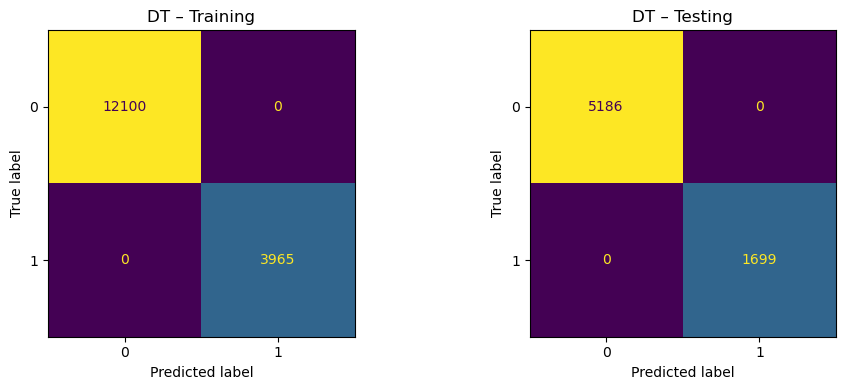


If train acc >> test acc, the tree overfits. Consider limiting max_depth/min_samples_leaf or using ccp_alpha pruning.


In [45]:
# 6) Decision Tree Model

print("\n=== Decision Tree ===")
dt = DecisionTreeClassifier(criterion='gini', random_state=42)
dt.fit(X_train, y_train)

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt  = dt.predict(X_test)

acc_tr_dt = accuracy_score(y_train, y_train_pred_dt)
acc_te_dt = accuracy_score(y_test,  y_test_pred_dt)
print(f"Training accuracy: {acc_tr_dt:.4f}")
print(f"Testing  accuracy: {acc_te_dt:.4f}")
print("\nClassification report (TEST):")
print(classification_report(y_test, y_test_pred_dt, digits=4))

# Confusion matrices (explicit labels to avoid multilabel error)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cm_tr = confusion_matrix(y_train, y_train_pred_dt, labels=[0, 1])
cm_te = confusion_matrix(y_test,  y_test_pred_dt,  labels=[0, 1])

ConfusionMatrixDisplay(cm_tr, display_labels=[0, 1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title("DT – Training")

ConfusionMatrixDisplay(cm_te, display_labels=[0, 1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title("DT – Testing")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dt_confusion_matrices.png"), dpi=150)
plt.show()

# Optional: preview a shallow part of the tree for readability
# fig, ax = plt.subplots(figsize=(14, 10))
# plot_tree(dt, max_depth=3, filled=True)
# plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "dt_tree_preview.png"), dpi=150)
# plt.show()

print("\nIf train acc >> test acc, the tree overfits. Consider limiting max_depth/min_samples_leaf or using ccp_alpha pruning.")

# 3. Artificial Neural Network 


=== Artificial Neural Network (MLP) ===
Unscaled – Train acc: 0.9946
Unscaled – Test  acc: 0.9588

Scaled   – Train acc: 0.9964
Scaled   – Test  acc: 0.9602


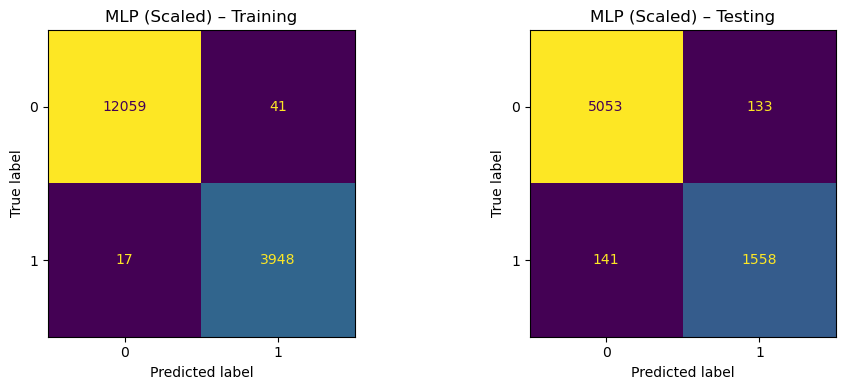


Did scaling help?
- Unscaled test acc: 0.9588
- Scaled   test acc: 0.9602


In [46]:
# 7) Artificial Neural Network
print("\n=== Artificial Neural Network (MLP) ===")

# Unscaled baseline
mlp_unscaled = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=500, tol=1e-4, random_state=42)
mlp_unscaled.fit(X_train, y_train)

y_train_pred_u = mlp_unscaled.predict(X_train)
y_test_pred_u  = mlp_unscaled.predict(X_test)

acc_tr_u = accuracy_score(y_train, y_train_pred_u)
acc_te_u = accuracy_score(y_test,  y_test_pred_u)
print(f"Unscaled – Train acc: {acc_tr_u:.4f}")
print(f"Unscaled – Test  acc: {acc_te_u:.4f}")

# Scaled version
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

mlp_scaled = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=500, tol=1e-4, random_state=42)
mlp_scaled.fit(X_train_sc, y_train)

y_train_pred_s = mlp_scaled.predict(X_train_sc)
y_test_pred_s  = mlp_scaled.predict(X_test_sc)

acc_tr_s = accuracy_score(y_train, y_train_pred_s)
acc_te_s = accuracy_score(y_test,  y_test_pred_s)
print(f"\nScaled   – Train acc: {acc_tr_s:.4f}")
print(f"Scaled   – Test  acc: {acc_te_s:.4f}")

# Confusion matrices (scaled MLP)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cm_tr_mlp = confusion_matrix(y_train, y_train_pred_s, labels=[0, 1])
cm_te_mlp = confusion_matrix(y_test,  y_test_pred_s,  labels=[0, 1])

ConfusionMatrixDisplay(cm_tr_mlp, display_labels=[0, 1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title("MLP (Scaled) – Training")

ConfusionMatrixDisplay(cm_te_mlp, display_labels=[0, 1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title("MLP (Scaled) – Testing")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "mlp_scaled_confusion_matrices.png"), dpi=150)
plt.show()

print("\nDid scaling help?")
print(f"- Unscaled test acc: {acc_te_u:.4f}")
print(f"- Scaled   test acc: {acc_te_s:.4f}")


Testing a few MLP configurations (scaled inputs)...
MLP hl=(5, 5), max_iter=500, tol=0.0001 -> Train=0.9864 | Test=0.9664
MLP hl=(10, 5), max_iter=500, tol=0.0001 -> Train=0.9964 | Test=0.9602
MLP hl=(20, 10, 10), max_iter=1000, tol=0.0001 -> Train=0.9910 | Test=0.9547

Best MLP by test acc: hl=(5, 5), max_iter=500, tol=0.0001 | Train=0.9864 | Test=0.9664


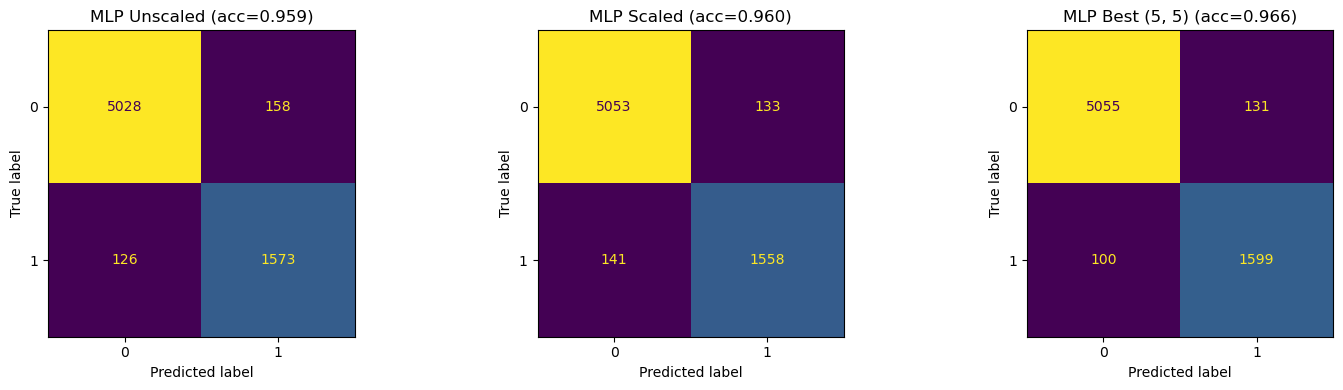

In [47]:
# 8) SIMPLE HYPERPARAM SWEEP (3 scenarios for report)
print("\nTesting a few MLP configurations (scaled inputs)...")
configs = [
    ((5, 5),      500, 1e-4),
    ((10, 5),     500, 1e-4),
    ((20, 10, 10),1000, 1e-4),
]
results = []
best = None

for hl, iters, tol in configs:
    m = MLPClassifier(hidden_layer_sizes=hl, max_iter=iters, tol=tol, random_state=42)
    m.fit(X_train_sc, y_train)
    ytr = m.predict(X_train_sc)
    yte = m.predict(X_test_sc)
    atr = accuracy_score(y_train, ytr)
    ate = accuracy_score(y_test,  yte)
    results.append((hl, iters, tol, atr, ate))
    print(f"MLP hl={hl}, max_iter={iters}, tol={tol} -> Train={atr:.4f} | Test={ate:.4f}")
    if best is None or ate > best[-1]:
        best = (hl, iters, tol, atr, ate)

print(f"\nBest MLP by test acc: hl={best[0]}, max_iter={best[1]}, tol={best[2]} | Train={best[3]:.4f} | Test={best[4]:.4f}")

# Save confusion matrices for three scenarios (unscaled, scaled, best)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm_u = confusion_matrix(y_test, y_test_pred_u, labels=[0, 1])
ConfusionMatrixDisplay(cm_u, display_labels=[0, 1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title(f"MLP Unscaled (acc={acc_te_u:.3f})")

cm_s = confusion_matrix(y_test, y_test_pred_s, labels=[0, 1])
ConfusionMatrixDisplay(cm_s, display_labels=[0, 1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title(f"MLP Scaled (acc={acc_te_s:.3f})")

# Refit best to get predictions for the plot
best_hl, best_it, best_tol = best[0], best[1], best[2]
best_m = MLPClassifier(hidden_layer_sizes=best_hl, max_iter=best_it, tol=best_tol, random_state=42)
best_m.fit(X_train_sc, y_train)
y_best = best_m.predict(X_test_sc)
cm_b = confusion_matrix(y_test, y_best, labels=[0, 1])
ConfusionMatrixDisplay(cm_b, display_labels=[0, 1]).plot(ax=axes[2], colorbar=False)
axes[2].set_title(f"MLP Best {best_hl} (acc={best[4]:.3f})")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "mlp_three_scenarios.png"), dpi=150)
plt.show()
